# Laboratorio: Consumiendo un modelo de Machine Learning

**Antes de empezar debemos cerciorarnos que el servidor de la parte anterior esté aún corriendo.**

En este notebook construiremos un cliente muy simple usando la biblioteca `requests` para interactuar con el servidor.

In [42]:
import os
import io
import cv2
import requests
import numpy as np
from IPython.display import Image, display

## Entendiendo la URL


Luego de experimentar usando fastAPI pudimos notar que hicimos todas las solicitudes apuntando una URL específica y le agregamos algunos parámetros.

De forma más concreta:

1. El servidor está alojado en la URL [http://localhost:8000/](http://localhost:8000/).
2. El endpoint que sirve el modelo es `/predict`.

Además podemos especificar que modelo usar:  `yolov3` o`yolov3-tiny`. 

In [43]:
base_url = 'http://localhost:8000'
endpoint = '/predict'
model = 'yolov3-tiny'

Para consumir el modelo, vamos a agregar el endpoint a la URL base para obtener la URL completa.

In [44]:
url_with_endpoint_no_params = base_url + endpoint
url_with_endpoint_no_params

'http://localhost:8000/predict'

Para agregar los parámetros que deseamos, tenemos que usar la sintaxis de agregar un caracter "?" seguido del nombre del parámetro y su valor.

Si lo hacemos la URL final quedaría en algo como esto:

In [45]:
full_url = url_with_endpoint_no_params + "?model=" + model + '&conf=0.5'
full_url

'http://localhost:8000/predict?model=yolov3-tiny&conf=0.5'

Pero este endpoint no solo espera el nombre del modelo sino que también una imagen. Pero como la imagen es algo más complejo como para pasarlo dentro de la URL, necesitamos usar la bilbioteca `requests` para manejar ese proceso.

# Enviando una solicitud al servidor

### Creando la función response_from_server

Como recordatorio, este endpoint espera una solicitud HTTP POST. La función `post` es parte de la biblioteca `requests`. 

Para pasar la imagen junto a la solicitud, necesitamos crear un diccionario indicando el nombre del archivo ('file' en este caso) y el archivo propiamente tal.

 `status code` es un comando útil para verificar el estado de la respuesta que la solicitud generó. **Un código de estado 200 significa que todo funcionó bien.**

In [46]:
def response_from_server(url, image_file, verbose=True):
    """Hace una solicitud POST al servidor y retorna la respuesta.

    Argumentos:
        url (str): URL a la que se envía la consulta.
        image_file (_io.BufferedReader): Archivo a subir, debe ser una imagen.
        verbose (bool): True si se debe imprimir el estado de la solicitud. False en otro caso.

    Retorna:
        requests.models.Response: Respuesta del servidor.
    """
    
    files = {'file': image_file}
    response = requests.post(url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "¡Todo funcionó bien!" if status_code == 200 else "Hubo un error al ejecutar la solicitud."
        print(msg)
    return response

Para probar la función, abriremos un archivo y lo pasaremos como un parámetro junto a la URL:

In [47]:
with open("images/fruits.jpg", "rb") as image_file:
    prediction = response_from_server(full_url, image_file)

¡Todo funcionó bien!


La solicitud fue exitosa. Pero no estamos obteniendo la información acerca de los objetos que están en la imagen.

Para obtener la imagen junto a sus cajas delimitadoras y etiquetas, tenemos que analizar el contenido de la respuesta y convertirlo a un formato apropiado.

Para manejar esto creemos un directorio llamado `images_predicted` para guardar las imagenes:

In [48]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)


### Creando la función display_image_from_response

In [49]:
def display_image_from_response(response):
    """Despliega la imagen de la respuesta del servidor.

    Argumentos:
        response (requests.models.Response): La respuesta del servidor luego de la detección de objetos
    """
    
    image_stream = io.BytesIO(response.content)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    filename = "image_with_objects.jpeg"
    cv2.imwrite(f'images_predicted/{filename}', image)
    display(Image(f'images_predicted/{filename}'))

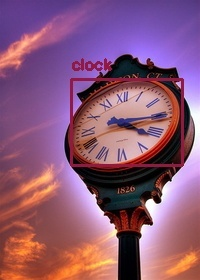

In [50]:
display_image_from_response(prediction)

Probemos con otras imágenes:

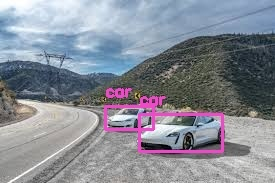

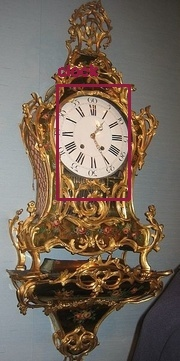

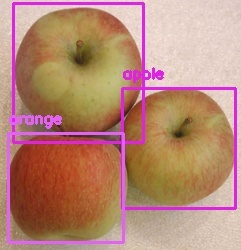

In [51]:
image_files = [
    'car2.jpg',
    'clock3.jpg',
    'apples.jpg'
]

for image_file in image_files:
    with open(f"images/{image_file}", "rb") as image_file:
        prediction = response_from_server(full_url, image_file, verbose=False)
    
    display_image_from_response(prediction)

**¡Con esto finalizamos el Laboratorio!** Tener clientes y servidores en la vida real conlleva un montón de otras cosas en términos de seguridad y desempeño. Pero de todas formas este código se asemeja bastante a la base de lo que ocurre en ambientes de producción. Ya revisamos los conceptos fundamentales para implementar un modelo y consumirlo.